<h1 align="center" style="font-weight: bold; font-size: 48px;">Rotten Tomatoes - Audience Rating Prediction</h1>



<img src="https://www.rottentomatoes.com/assets/pizza-pie/images/rottentomatoes_logo_40.336d6fe66ff.png" alt="Rotten Tomatoes">


## **Author**

James Jeberson M - (for feedback reach out to jamesjebersonm@gmail.com)

# **Introduction**
## Objective:
1. Preprocess and transform data, including handling missing values and encoding features.
2. Build and evaluate multiple regression models to predict audience ratings.
    - Linear Regression (Ridge & Lasso)
    - XGBoost Regressor
    - CatBoost Regressor
    - Neural Networks
3. Compare model performance using metrics like RMSE and R² to identify the best model.

# **Importing the required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from textblob import TextBlob
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import root_mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# **Data Loading**

In [2]:
# loading the dataset as a pandas dataframe
rt_df = pd.read_excel("Rotten_Tomatoes_Movies3.xls")
print(f"The Rotten Tomatoes Dataset contains {rt_df.shape[0]} rows and {rt_df.shape[1]} columns")

The Rotten Tomatoes Dataset contains 16638 rows and 16 columns


In [3]:
# looking at the dataset
rt_df.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


In [4]:
# looking at the schema of the dataset
rt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

# **Handling Duplicates**

## Handling Duplicates in Rows

In [5]:
# checking for duplicates in the dataset
rt_df.duplicated().max()

True

**There are duplicate rows present in the datset**

In [6]:
# Checking for the count of duplicate rows
rt_df.duplicated().sum()

1

**There is only 1 duplicated row**

In [7]:
# viewing the duplicated rows
rt_df[rt_df.duplicated(keep=False)]

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
8495,King Charles III,An adaptation of the Broadway drama about Prin...,NaN,NR,Drama,Rupert Goold,Mike Bartlett,"Oliver Chris, Richard Goulding, Charlotte Rile...",2017-05-14,2017-06-27,88.0,NaN,Fresh,100,9,48.0
8496,King Charles III,An adaptation of the Broadway drama about Prin...,NaN,NR,Drama,Rupert Goold,Mike Bartlett,"Oliver Chris, Richard Goulding, Charlotte Rile...",2017-05-14,2017-06-27,88.0,NaN,Fresh,100,9,48.0


In [8]:
# dropping the duplicated row
rt_df = rt_df.drop_duplicates()

In [9]:
# verifying for duplicates
rt_df.duplicated().max()

False

**No duplicate rows are present in the dataset**

# **Exploring the Dataset**

In [10]:
# extracting numerical and categorical/Textual columns
txt_col = []
num_col = []
for col in rt_df.columns:
    if rt_df[col].dtype == 'O':
        txt_col.append(col)
    else:
        num_col.append(col)

In [11]:
print(f"Categorical/Textual columns: {txt_col}")
print(f"Numerical columns: {num_col}")

Categorical/Textual columns: ['movie_title', 'movie_info', 'critics_consensus', 'rating', 'genre', 'directors', 'writers', 'cast', 'studio_name', 'tomatometer_status']
Numerical columns: ['in_theaters_date', 'on_streaming_date', 'runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count', 'audience_rating']


## Exploring Numerical Columns

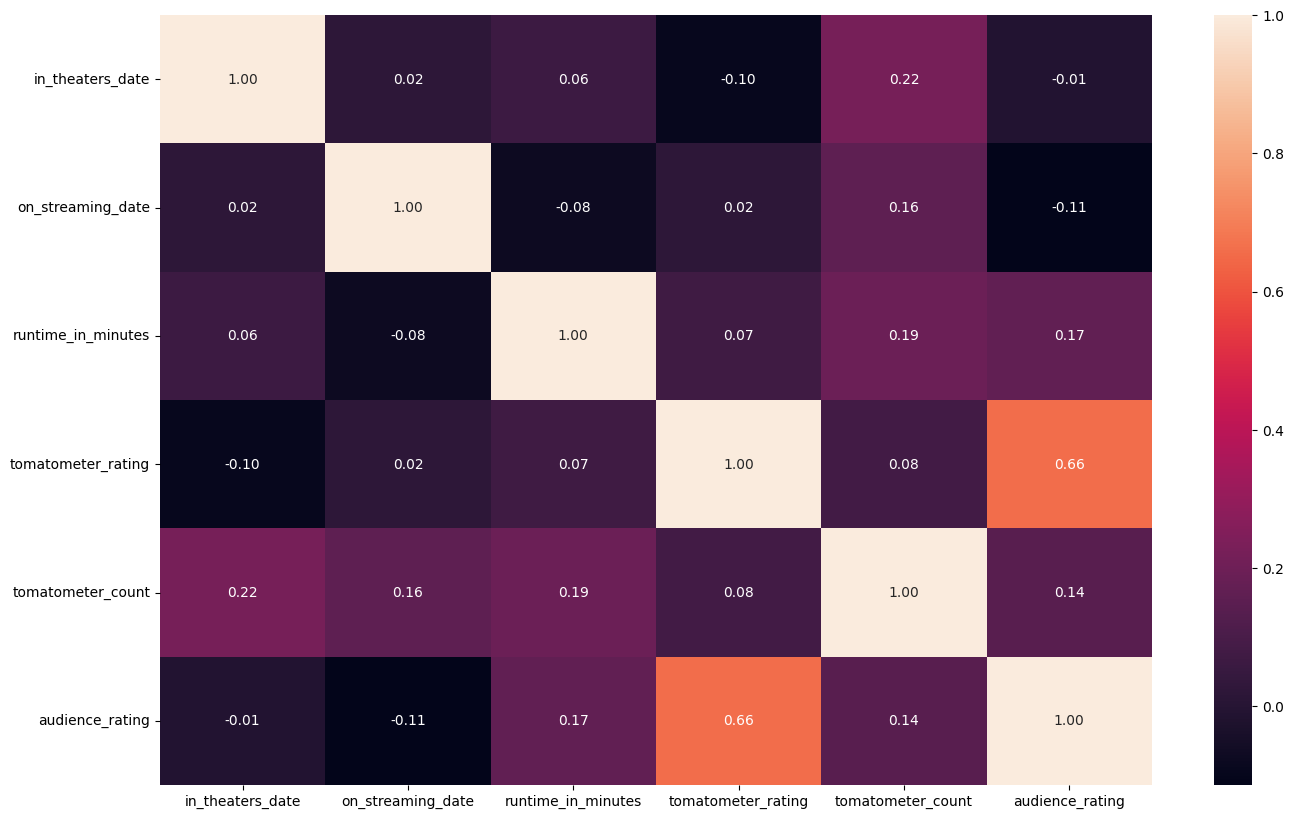

In [12]:
# visulaizing correlation between numerical columns
plt.figure(figsize = (16, 10))
sns.heatmap(rt_df[[col for col in num_col]].corr(), annot = True, fmt = '.2f')
plt.show()

**Observation**

1. High correlation between **tomatometer_rating** & **audience_rating**
2. Negligible correlation between other features/columns with **audience_rating**

## Exploring Categorical/Textual Columns

In [13]:
txt_status = {'Feature':[], 'Unique Values':[] }
for col in txt_col:
    txt_status['Feature'].append(col)
    txt_status['Unique Values'].append(len(rt_df[col].dropna().unique()))
pd.DataFrame(txt_status)

,Feature,Unique Values
0,movie_title,16106
1,movie_info,16613
2,critics_consensus,8307
3,rating,8
4,genre,1080
5,directors,8314
6,writers,12121
7,cast,16326
8,studio_name,2886
9,tomatometer_status,3


**Observation**

It can be observed that except 'rating' & 'tomatometer_status' remaining columns have too many unique values with suggests that we consider them as textual columns while 'rating' & 'tomatometer_status' are considered as categorical columns

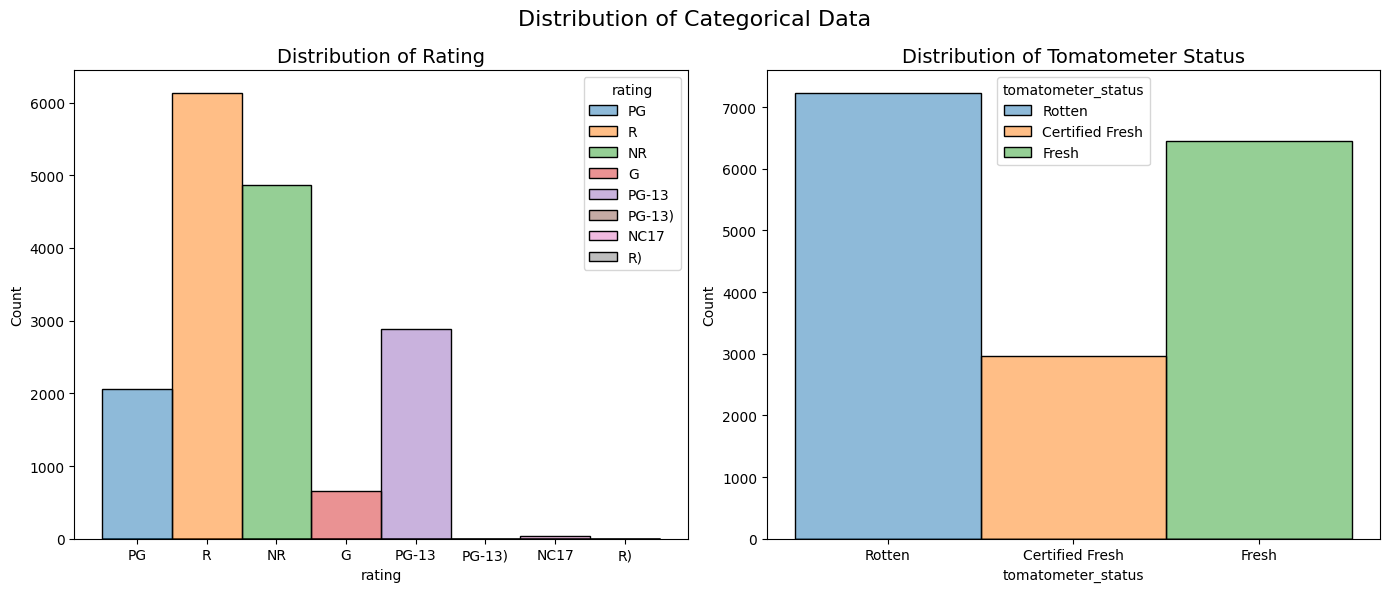

In [14]:
# Visualizing categorical columns 'rating' & 'tomatometer_status'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(rt_df, x='rating', hue='rating', ax=ax1)
ax1.set_title('Distribution of Rating', fontsize=14)

sns.histplot(rt_df, x='tomatometer_status', hue='tomatometer_status', ax=ax2)
ax2.set_title('Distribution of Tomatometer Status', fontsize=14)

fig.suptitle('Distribution of Categorical Data', fontsize=16)
plt.tight_layout()
plt.show()


**Observation**

From above in Distribution of Rating we can see that 'PG-13)' and 'R)' has typo in them, lets fix them.

In [15]:
# fixing typo in dataset
rt_df['rating'] = rt_df['rating'].replace({'PG-13)': 'PG-13', 'R)': 'R'})

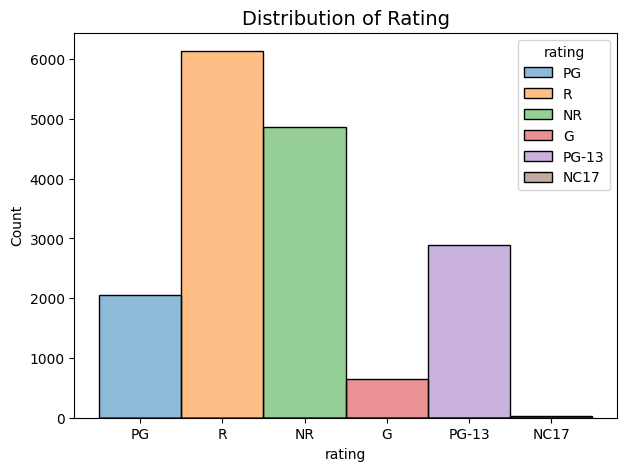

In [16]:
# visulizing the result
plt.figure(figsize = (7,5))
sns.histplot(rt_df, x='rating', hue='rating')
plt.title('Distribution of Rating', fontsize=14)
plt.show()

**Typo issue has been fixed**

# **Handling missing values**

## Handling missing values in Target variable

In [17]:
# checking for missing values in target variable 'audience_rating'
print(f"No of missing values in audience_rating: {rt_df['audience_rating'].isna().sum()}")

No of missing values in audience_rating: 252


**Observation**

There are 252 missing values in audience_rating. Since it is the target trying to fill these missing values will introduce bias into the model. Hence we will drop the rows with missing values in audience_rating

In [18]:
# dropping columns with missing values in audience_rating
rt_df = rt_df.dropna(subset=['audience_rating'])

In [19]:
# verifying
print(f"No of missing values in audience_rating: {rt_df['audience_rating'].isna().sum()}")

No of missing values in audience_rating: 0


**Missing values in audience_rating has been handled (Target)**

## Handling missing values in numerical columns

In [20]:
# total missing values in numerical columns
pd.concat([rt_df[num_col].count(), rt_df[num_col].isna().sum(), round((rt_df[num_col].isna().sum()/len(rt_df))*100, 2)], 
          axis = 1, 
          keys = ["Total Count of Values", "Total Missing Values", "Percent of Missing Values"])

,Total Count of Values,Total Missing Values,Percent of Missing Values
in_theaters_date,15666,719,4.39
on_streaming_date,16384,1,0.01
runtime_in_minutes,16238,147,0.90
tomatometer_rating,16385,0,0.00
tomatometer_count,16385,0,0.00
audience_rating,16385,0,0.00


<Axes: >

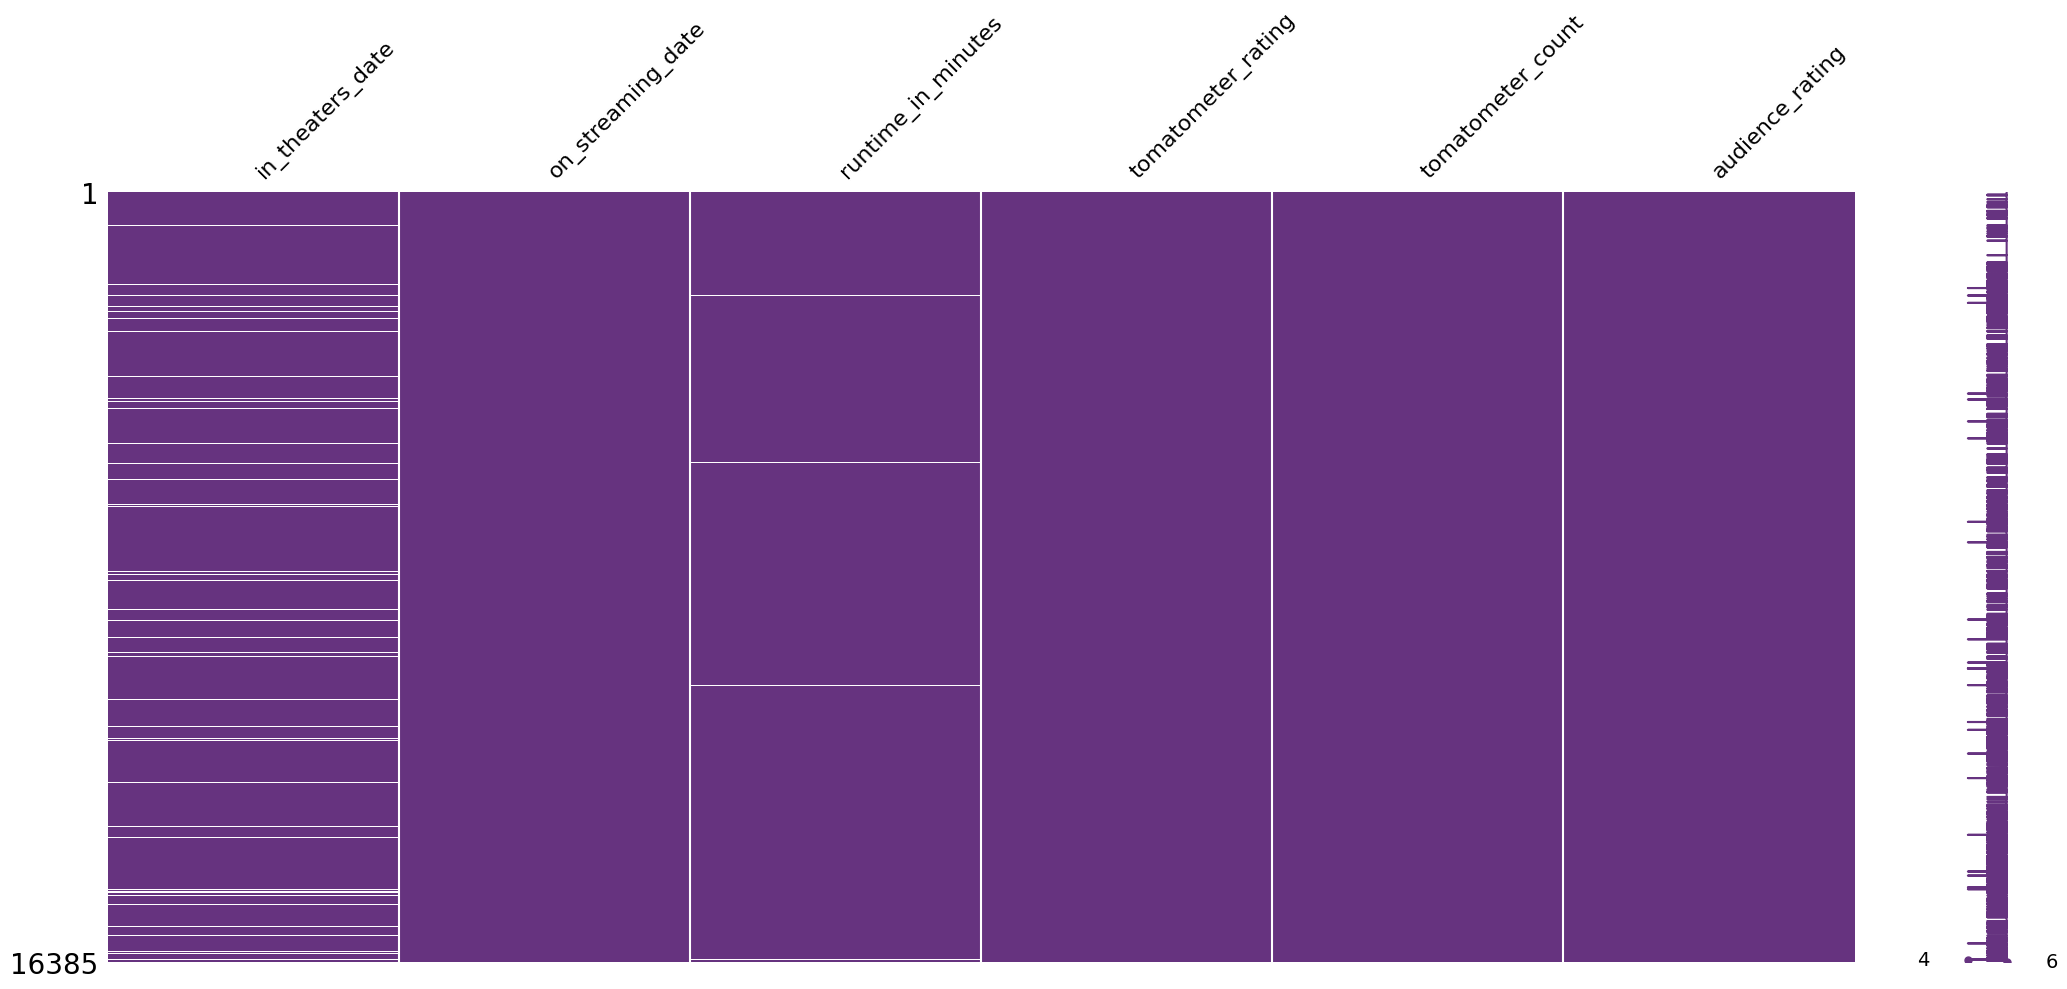

In [21]:
# visualizing missing values in the dataset with numerical columns
msno.matrix(rt_df[num_col], color=(0.4,0.2,0.5))

In [22]:
missing_num_col = [col for col in num_col if rt_df[col].isna().sum() > 0]
missing_num_col

['in_theaters_date', 'on_streaming_date', 'runtime_in_minutes']

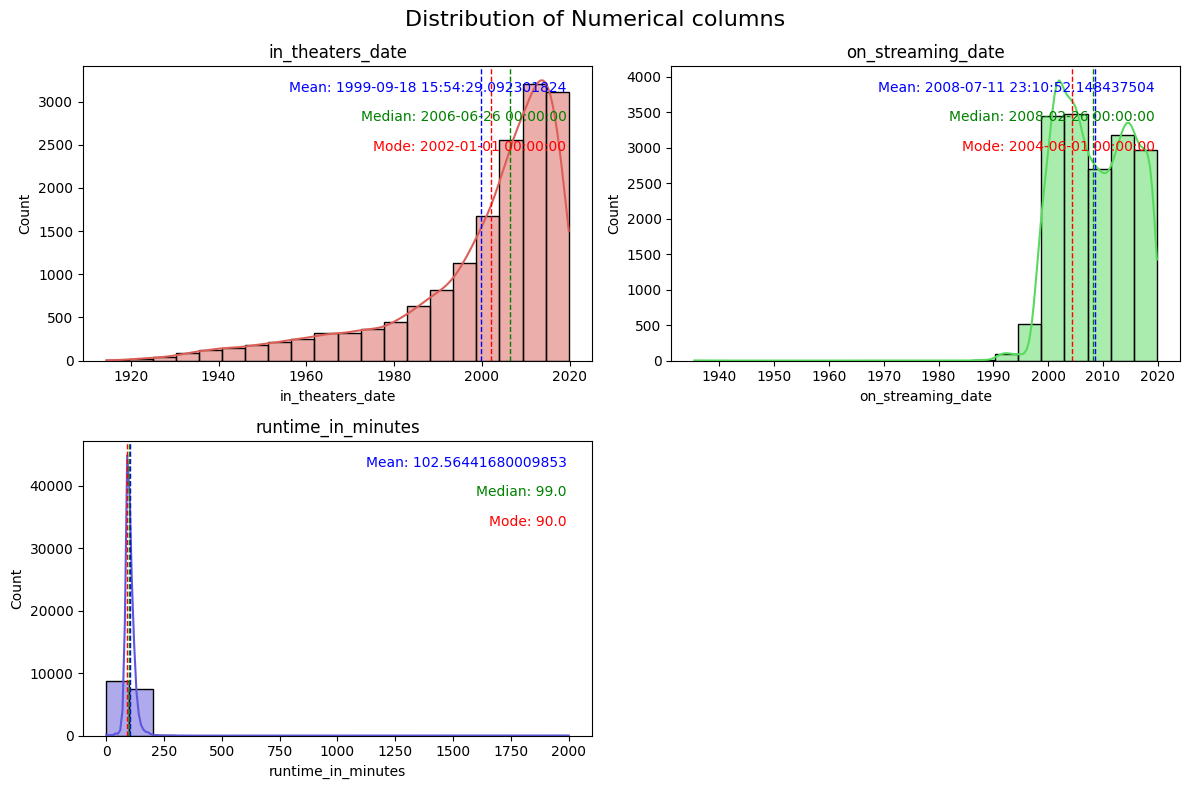

In [23]:
# creating histograms for all the numerical columns with missing values
missing_num_col = [col for col in num_col if rt_df[col].isna().sum() > 0]

number_cols = len(missing_num_col)
cols = 2
rows = (number_cols//cols+1)

fig, axis = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 4*rows))

axis = axis.flatten()

for i, col in enumerate(missing_num_col):
    sns.histplot(rt_df, x=col, kde=True, bins = 20, color=sns.color_palette('hls', len(missing_num_col))[i], ax=axis[i])
    axis[i].set_title(col)
    axis[i].set_xlabel(col)
    axis[i].set_ylabel('Count')
    
    axis[i].text(0.95, 0.95, f"Mean: {rt_df[col].mean()}", ha='right', va='top', transform=axis[i].transAxes, fontsize=10, color='blue')
    axis[i].text(0.95, 0.85, f"Median: {rt_df[col].median()}", ha='right', va='top', transform=axis[i].transAxes, fontsize=10, color='green')
    axis[i].text(0.95, 0.75, f"Mode: {rt_df[col].mode()[0]}", ha='right', va='top', transform=axis[i].transAxes, fontsize=10, color='red')
    
    axis[i].axvline(rt_df[col].mean(), color='blue', linestyle='dashed', linewidth=1)
    axis[i].axvline(rt_df[col].median(), color='green', linestyle='dashed', linewidth=1)
    axis[i].axvline(rt_df[col].mode()[0], color='red', linestyle='dashed', linewidth=1)
    
    
for i in range(number_cols, len(axis)):
    axis[i].axis('off')

fig.suptitle('Distribution of Numerical columns', fontsize=16)
plt.tight_layout()
plt.show()

**Observation**
1. **runtime_in_minutes** has an almost symmetrical distribution hence we go with **mean imputation** to fill missing values
2. **in_theaters_date** and **on_streaming_date** have skewed distribution hebce we go with **median impytation** to dill missing values

In [24]:
# mean imputation
# filling missing values in 'runtime_in_minutes' using mean
rt_df['runtime_in_minutes']=rt_df['runtime_in_minutes'].fillna(rt_df['runtime_in_minutes'].mean())

In [25]:
# median imputation
# filling missing values using median
for col in ['in_theaters_date', 'on_streaming_date']:
    rt_df[col]=rt_df[col].fillna(rt_df[col].median())

In [26]:
# verifying 
print(f"Missing values in numeric columns: {rt_df[[col for col in num_col]].isna().max().sum()}")

Missing values in numeric columns: 0


**Missing values in numeric columns has been handled**

## Handling missing values in Categorical/Textual columns

In [27]:
# total missing values in Categorical/Textual columns
pd.concat([rt_df[txt_col].count(), rt_df[txt_col].isna().sum(), round((rt_df[txt_col].isna().sum()/len(rt_df))*100, 2)], 
          axis = 1, 
          keys = ["Total Count of Values", "Total Missing Values", "Percent of Missing Values"])

,Total Count of Values,Total Missing Values,Percent of Missing Values
movie_title,16385,0,0.00
movie_info,16367,18,0.11
critics_consensus,8281,8104,49.46
rating,16385,0,0.00
genre,16368,17,0.10
directors,16281,104,0.63
writers,15108,1277,7.79
cast,16125,260,1.59
studio_name,16010,375,2.29
tomatometer_status,16385,0,0.00


<Axes: >

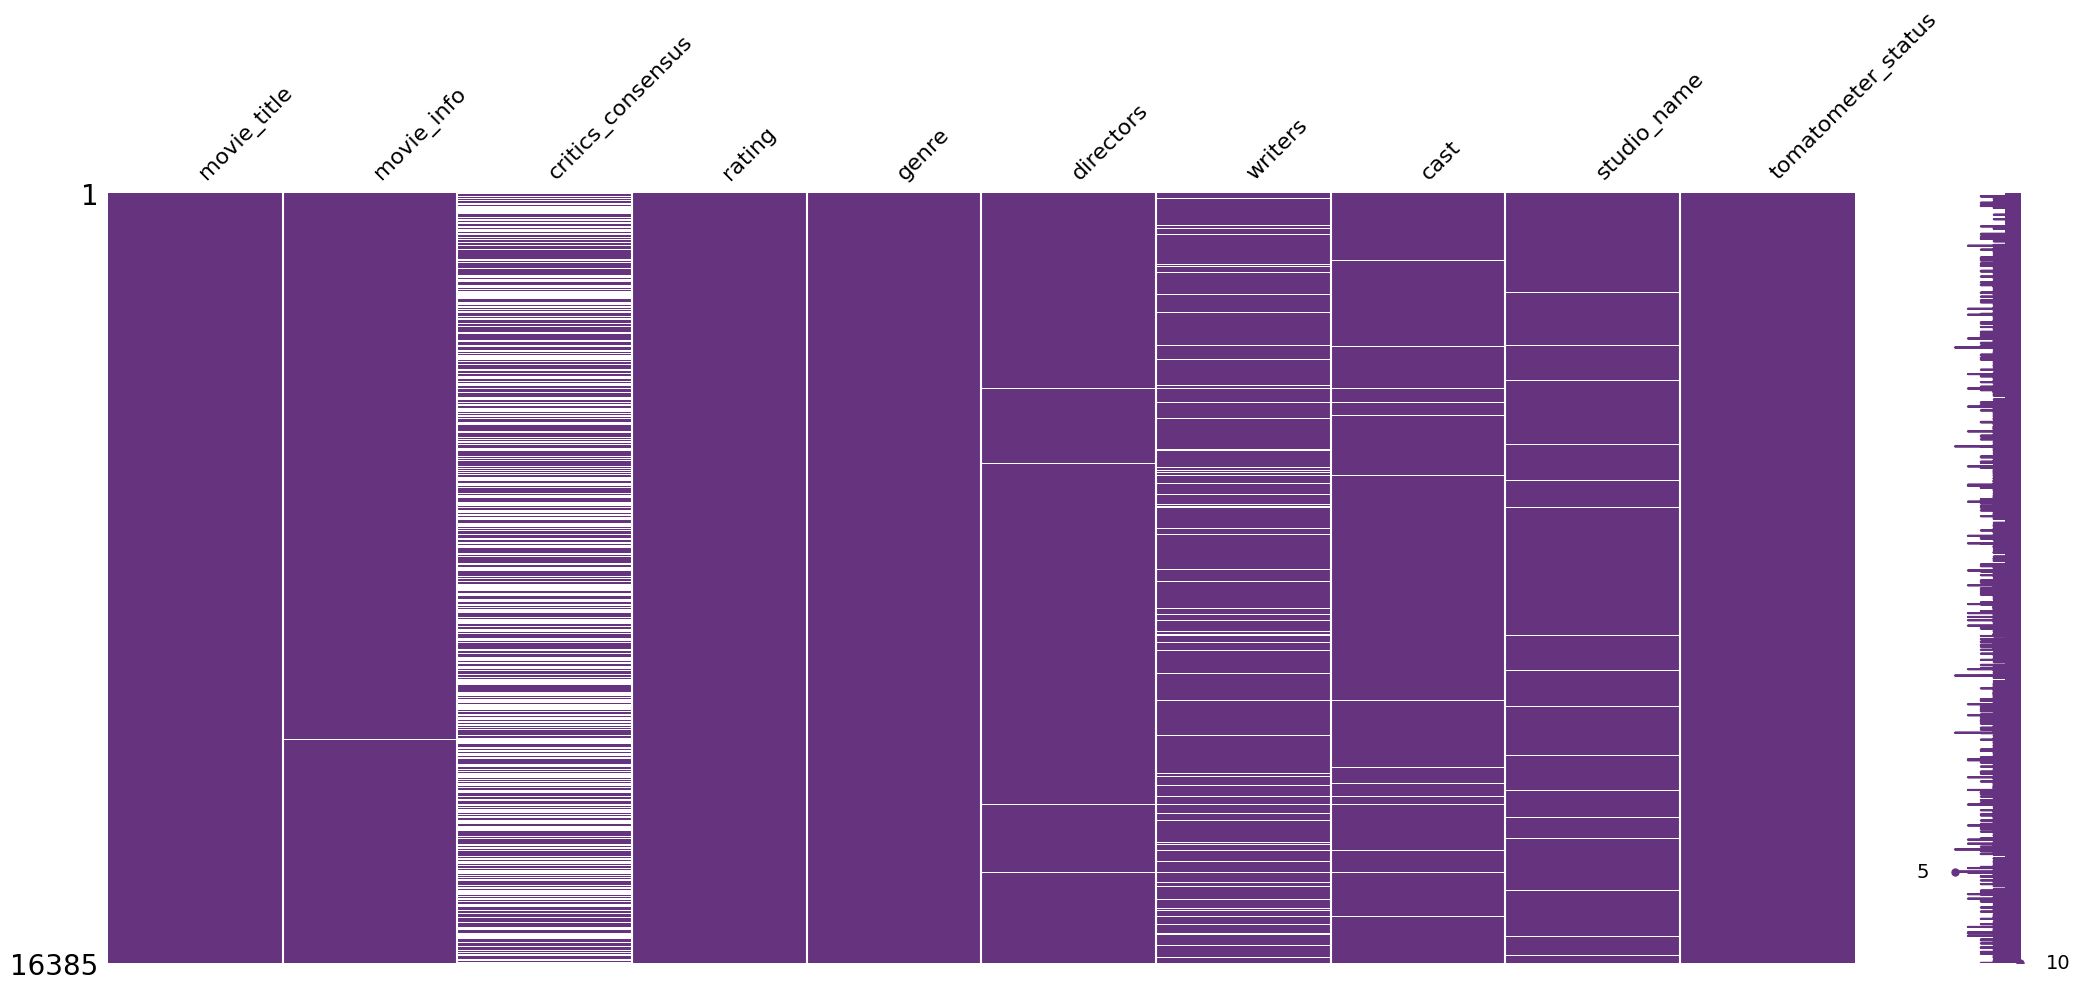

In [28]:
# visualizing missing values in the dataset with Categorical/Textual columns
msno.matrix(rt_df[txt_col], color=(0.4,0.2,0.5))

In [29]:
missing_txt_col = [col for col in txt_col if rt_df[col].isna().sum() > 0]
print(missing_txt_col)

['movie_info', 'critics_consensus', 'genre', 'directors', 'writers', 'cast', 'studio_name']


**Observation**
1. **critics_consensus** has near 50% missing values but it contains info which might be relevant and impact the target (audience_rating). Hence lets transform the values using sentiment analysis.
2. **'movie_info', 'genre', 'directors', 'writers', 'cast', 'studio_name'** have considerably less missing values but mean, median or mode imputation cannot be used as each value is highly associated to the movie, hence here we will use placeholders.

### Transforming 'critics_consensus'

In [30]:
# taking a copy of the current dataset before processing 'critics_consensus' as it will be need in later 
critics_consensus_df = rt_df

In [31]:
# transforming 'critics_consensus' column
def classify_sentiment(text):
    if pd.isnull(text):
        return 'Unknown'
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

rt_df['critics_sentiment'] = rt_df['critics_consensus'].apply(classify_sentiment)
rt_df['critics_sentiment'].value_counts()

critics_sentiment
Unknown     8104
Positive    5717
Negative    2122
Neutral      442
Name: count, dtype: int64

In [32]:
# Dropping 'critics_consensus' column
rt_df = rt_df.drop(columns=['critics_consensus'])

# Fill missing values in text columns with placeholders
rt_df['movie_info'] = rt_df['movie_info'].fillna('Unknown')
rt_df['genre'] = rt_df['genre'].fillna('Unknown Genre')
rt_df['directors'] = rt_df['directors'].fillna('Unknown Director')
rt_df['writers'] = rt_df['writers'].fillna('Unknown Writer')
rt_df['cast'] = rt_df['cast'].fillna('Unknown Cast')
rt_df['studio_name'] = rt_df['studio_name'].fillna('Unknown Studio')

In [33]:
# verifying 
txt_col.remove('critics_consensus')
print(f"Missing values in Categorical/Textual columns: {rt_df[[col for col in txt_col]].isna().max().sum()}")

Missing values in Categorical/Textual columns: 0


## Verifying whole dataset for missing values

In [34]:
print(f"Missing values: {rt_df.isna().max().sum()}")

Missing values: 0


<Axes: >

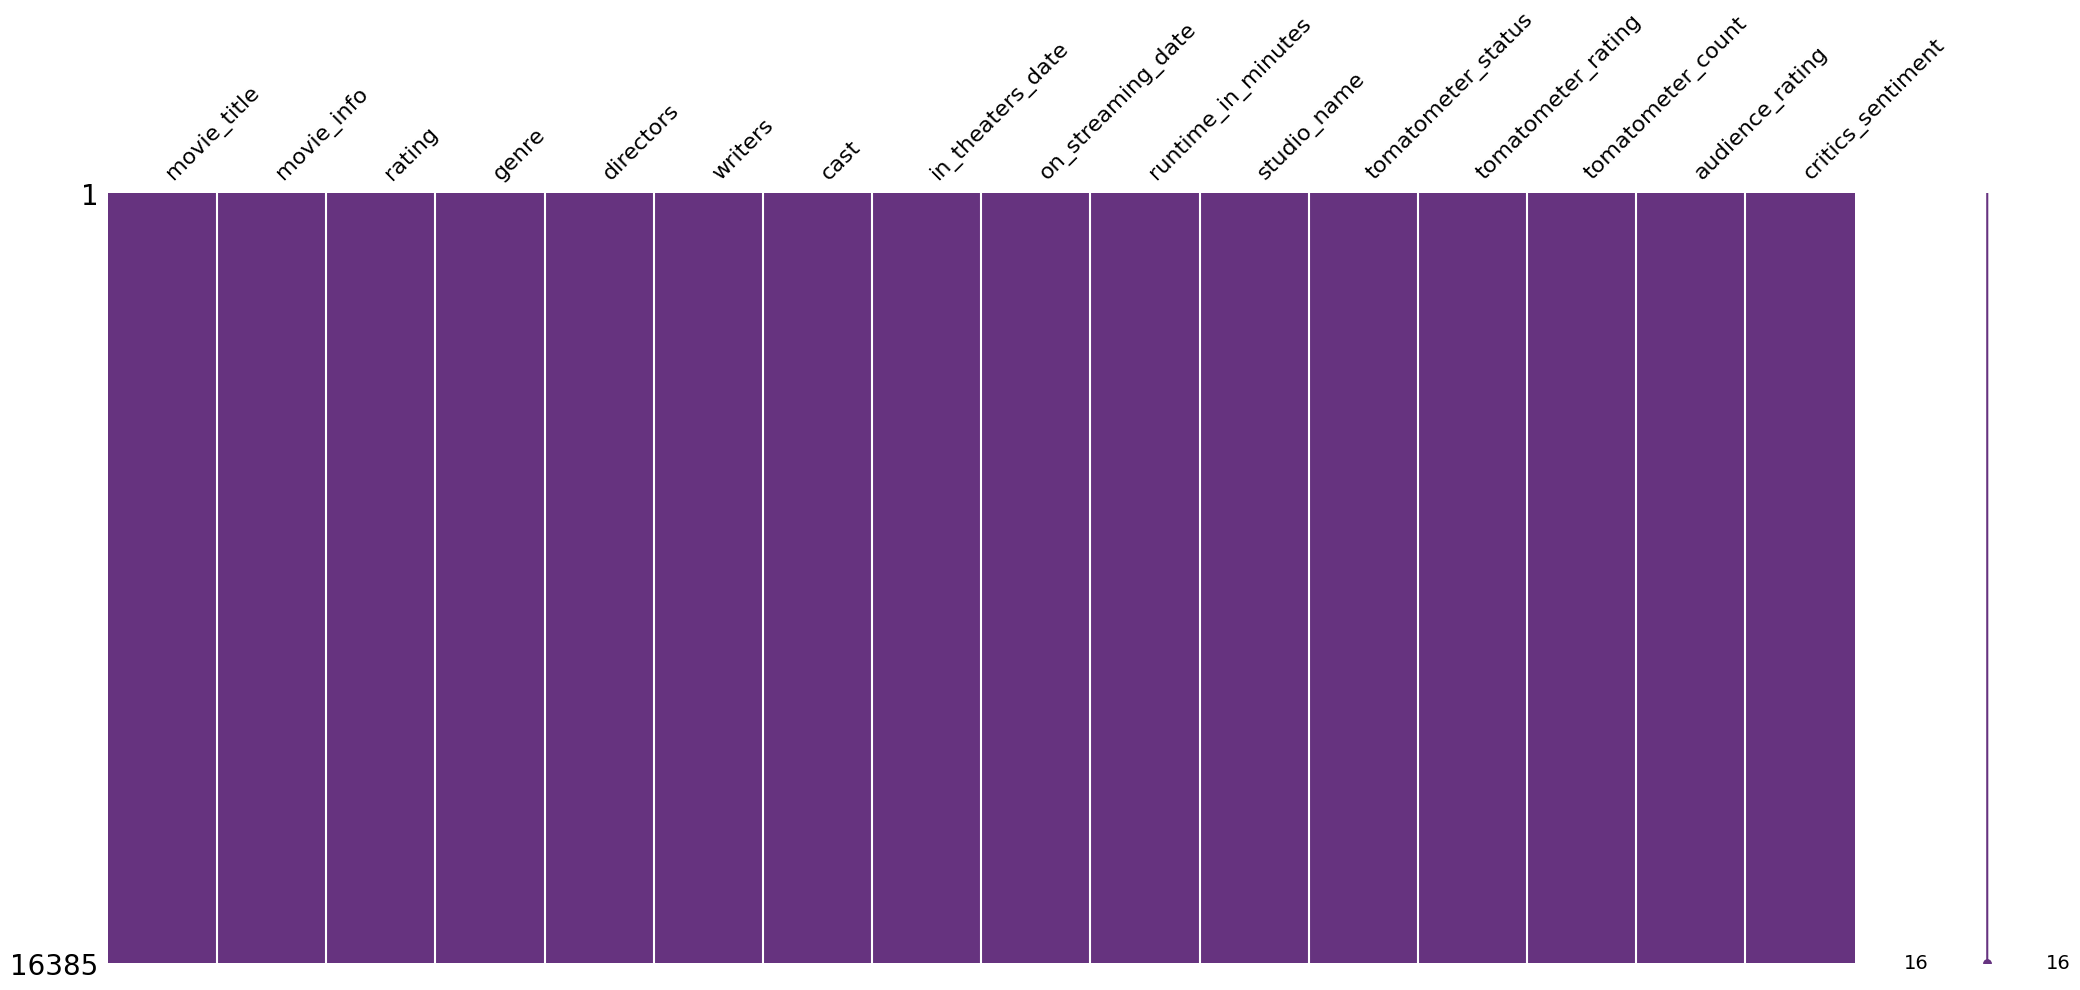

In [35]:
msno.matrix(rt_df, color=(0.4,0.2,0.5))

**Missing values has been handled**

# **Feature Encoding**

## Encoding Date Columns

In [36]:
rt_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16385 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16385 non-null  object        
 1   movie_info          16385 non-null  object        
 2   rating              16385 non-null  object        
 3   genre               16385 non-null  object        
 4   directors           16385 non-null  object        
 5   writers             16385 non-null  object        
 6   cast                16385 non-null  object        
 7   in_theaters_date    16385 non-null  datetime64[ns]
 8   on_streaming_date   16385 non-null  datetime64[ns]
 9   runtime_in_minutes  16385 non-null  float64       
 10  studio_name         16385 non-null  object        
 11  tomatometer_status  16385 non-null  object        
 12  tomatometer_rating  16385 non-null  int64         
 13  tomatometer_count   16385 non-null  int64         


In [37]:
# Encoding Dates into day, month and year

# Encoding in_theaters_date
rt_df['in_theaters_day'] = rt_df['in_theaters_date'].dt.day
rt_df['in_theaters_month'] = rt_df['in_theaters_date'].dt.month
rt_df['in_theaters_year'] = rt_df['in_theaters_date'].dt.year

# Encoding on_streaming_date
rt_df['on_streaming_day'] = rt_df['on_streaming_date'].dt.day
rt_df['on_streaming_month'] = rt_df['on_streaming_date'].dt.month
rt_df['on_streaming_year'] = rt_df['on_streaming_date'].dt.year

# droping in_theaters_date & on_streaming_date
rt_df.drop(columns={'in_theaters_date', 'on_streaming_date'}, inplace=True)

## Encoding Category Columns

In [38]:
# OneHot encoding 'rating', 'tomatometer_status' & 'critics_sentiment'
rt_df = pd.get_dummies(rt_df, columns=['rating', 'tomatometer_status', 'critics_sentiment'])

# Replacing True & False with 1 & 0
rt_df = rt_df.replace({True: 1, False: 0})

In [39]:
# Lets check if we can encode other textual columns
# most of them seems to be seperated by commas
for column in [col for col in rt_df.columns if rt_df[col].dtype == 'O']:
    unique_values = set(
                        str(value).strip() 
                        for values in rt_df[column] 
                            for value in str(values).split(',')
                        )
    print(f"Number of unique values in {column}: {len(unique_values)}")

Number of unique values in movie_title: 16068
Number of unique values in movie_info: 129530
Number of unique values in genre: 22
Number of unique values in directors: 8848
Number of unique values in writers: 14514
Number of unique values in cast: 197742
Number of unique values in studio_name: 2827


**Observations & Actions**
1. **genre** has 22 unique values this needs to be encoded
2. **movie_title** can be dropped as it does not have impact on audience_rating
3. **movie_info** can also be droped as transforming it does not make sense and most of its content is already captured in **genre** column
4. **directors, writers, cast, studio_name** lets try to frequency encode these columns

### Multi Lable Encoding

In [40]:
# Encoding 'genre' column
genre_lists = rt_df['genre'].apply(lambda x: [i.strip() for i in str(x).split(',')])

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(genre_lists), columns=mlb.classes_, index=rt_df.index)

rt_df = pd.concat([rt_df, genre_encoded], axis=1).drop(columns=['genre'])

In [41]:
# dropping 'movie_title' and 'movie_info' columns
rt_df.drop(columns=['movie_title', 'movie_info'], inplace=True)

### Frequency Encoding

In [42]:
# encoding directors, writers, cast & studio_name
def frequency_encode(column):

    all_values = [value.strip() for item in column for value in str(item).split(',')]
    frequency = pd.Series(all_values).value_counts()
    return column.apply(lambda x: sum(frequency.get(value.strip()) for value in str(x).split(',')))

rt_df['directors_freq'] = frequency_encode(rt_df['directors'])
rt_df['writers_freq'] = frequency_encode(rt_df['writers'])
rt_df['cast_freq'] = frequency_encode(rt_df['cast'])
rt_df['studio_name_freq'] = frequency_encode(rt_df['studio_name'])

In [43]:
rt_df[['directors', 'directors_freq', 'writers', 'writers_freq', 'cast', 'cast_freq', 'studio_name', 'studio_name_freq']].head()

,directors,directors_freq,writers,writers_freq,cast,cast_freq,studio_name,studio_name_freq
0,Chris Columbus,13,Craig Titley,2,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",719,20th Century Fox,414
1,Nicole Holofcener,5,Nicole Holofcener,6,"Catherine Keener, Amanda Peet, Oliver Platt, R...",260,Sony Pictures Classics,259
2,Blake Edwards,27,Blake Edwards,21,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",315,Waner Bros.,1
3,Sidney Lumet,30,Reginald Rose,3,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",208,Criterion Collection,110
4,Richard Fleischer,17,Earl Felton,3,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",242,Disney,26


**Observation**

The columns **directors, writers, cast & studio_name** has been frequency encoded where each value for example 'Chris Columbus' is replaced with no of time times they appear in the dataset.

In [44]:
rt_df.loc[rt_df['directors'] == 'Unknown Director', ['directors', 'directors_freq']].sample(5)

,directors,directors_freq
12444,Unknown Director,104
8226,Unknown Director,104
3940,Unknown Director,104
11384,Unknown Director,104
5878,Unknown Director,104


**Observation**

The values which was used to fill the missing values in directors, writers, cast & studio_name has also been frequency encoded which we do not want. Hence we will replace all the frequesncy for these to 0. 

In [45]:
# replaceing frequency of unknown values with 0
rt_df.loc[rt_df['directors'] == 'Unknown Director', 'directors_freq'] = 0
rt_df.loc[rt_df['directors'] == 'Unknown Writer', 'writers'] = 0
rt_df.loc[rt_df['directors'] == 'Unknown Cast', 'cast'] = 0
rt_df.loc[rt_df['directors'] == 'Unknown Studio', 'studio_name'] = 0

In [46]:
# dropping directors, writers, cast & studio_name
rt_df.drop(columns = ['directors', 'writers', 'cast', 'studio_name'], inplace=True)

**Data Cleaning and Processing Complete**

In [47]:
# final dataset
print(f"The dataset has {rt_df.shape[0]} rows and {rt_df.shape[1]} Columns")

The dataset has 16385 rows and 49 Columns


# **Train Test Split**

In [48]:
# splitting dataset to train and test datasets

X = rt_df.drop(columns = 'audience_rating')
y = rt_df['audience_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"Train dataset shape = {X_train.shape}")
print(f"Test dataset shape = {X_test.shape}")

Train dataset shape = (13108, 48)
Test dataset shape = (3277, 48)


# **Feature Scaling - Normalization (Min-Max Scaling)**

In [49]:
scalar = MinMaxScaler()
scaled_X = scalar.fit_transform(X)

In [50]:
# scaled traing data will be used in the required ML model only
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = 42)

print(f"Scaled train dataset shape = {scaled_X_train.shape}")

Scaled train dataset shape = (13108, 48)


# **Linear Regression**

In [51]:
# creating a variable to store the results of all the models
model_perf = []
def evaluate_model(model, pred):
    rmse = round(root_mean_squared_error(y_test, pred), 2)
    r2 = round(r2_score(y_test, pred), 2)
    model_perf.append({'Model': model, 'RMSE': rmse, 'R Squared': r2})
    print(f"RMSE of {model}: {rmse}")
    print(f"R Squared of {model}: {r2}")

In [52]:
# initializing Linear Regression model
lreg = LinearRegression()

# training model with normalized dataset (since linear regression is sensitive to scale of values)
lreg.fit(scaled_X_train, y_train)

# predicting on scaled test dataset 
pred_lreg = lreg.predict(scaled_X_test)

# evaluating model
evaluate_model('Linear Regression', pred_lreg)

RMSE of Linear Regression: 14.01
R Squared of Linear Regression: 0.53


In [53]:
# checking for overfitting 
print(f"RMSE with train data: {root_mean_squared_error(y_train, lreg.predict(scaled_X_train)):.2f}")
print(f"R Squared with train data: {r2_score(y_train, lreg.predict(scaled_X_train)):.2f}")

RMSE with train data: 14.00
R Squared with train data: 0.53


In [54]:
# lets check the consitancy of the model accross different splits of the dataset
cv_scores = cross_val_score(lreg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Mean Cross-Validation RMSE: {(np.sqrt(-cv_scores)).mean():.2f}")

cv_r2 = cross_val_score(lreg, X_train, y_train, cv=5, scoring='r2')
print(f"Mean Cross-Validation R²: {cv_r2.mean():.2f}")

Mean Cross-Validation RMSE: 14.23
Mean Cross-Validation R²: 0.52


**Observation**

The RMSE and R Squared for both train dataset and test dataset are comparable which indicates that the model is not overfitting. From K fold cross validation the model is consistant across data splits.

# **Ridge and Lasso Regression**

In [55]:
# Ridge Regression
alpha = [0.1, 1.0, 10.0, 100.0]
for i in alpha:
    Rreg = Ridge(alpha=i, random_state=42)
    Rreg.fit(scaled_X_train, y_train)
    print(f"alpha = {i}")
    print(f"RMSE with test data: {root_mean_squared_error(y_test, Rreg.predict(scaled_X_test)):.2f}")
    print(f"R Squared with test data: {r2_score(y_test, Rreg.predict(scaled_X_test)):.2f}\n")

alpha = 0.1
RMSE with test data: 14.00
R Squared with test data: 0.53

alpha = 1.0
RMSE with test data: 14.03
R Squared with test data: 0.53

alpha = 10.0
RMSE with test data: 14.09
R Squared with test data: 0.52

alpha = 100.0
RMSE with test data: 14.23
R Squared with test data: 0.51



In [56]:
# Lasso Regression
alpha = [0.1, 1.0, 10.0, 100.0]
for i in alpha:
    Lareg = Lasso(alpha=i, random_state=42)
    Lareg.fit(scaled_X_train, y_train)
    print(f"alpha = {i}")
    print(f"RMSE with test data: {root_mean_squared_error(y_test, Lareg.predict(scaled_X_test)):.2f}")
    print(f"R Squared with test data: {r2_score(y_test, Lareg.predict(scaled_X_test)):.2f}\n") 

alpha = 0.1
RMSE with test data: 14.32
R Squared with test data: 0.51

alpha = 1.0
RMSE with test data: 15.62
R Squared with test data: 0.41

alpha = 10.0
RMSE with test data: 20.36
R Squared with test data: -0.00

alpha = 100.0
RMSE with test data: 20.36
R Squared with test data: -0.00



In [57]:
# best alpha value
Rreg = Ridge(alpha=0.1, random_state=42)
Rreg.fit(scaled_X_train, y_train)
evaluate_model('Ridge Linear Regression', Rreg.predict(scaled_X_test))

Lareg = Lasso(alpha=0.1, random_state=42)
Lareg.fit(scaled_X_train, y_train)
evaluate_model('Lasso Linear Regression', Lareg.predict(scaled_X_test))

RMSE of Ridge Linear Regression: 14.0
R Squared of Ridge Linear Regression: 0.53
RMSE of Lasso Linear Regression: 14.32
R Squared of Lasso Linear Regression: 0.51


# **Random Forest Regression**

In [58]:
# Initialize Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# Training the model
rf_reg.fit(X_train, y_train)

# Predicting on the test dataset
pred_rf_reg = rf_reg.predict(X_test)

# Evaluating the model
print(f"RMSE: {root_mean_squared_error(y_test, pred_rf_reg):.2f}")
print(f"R Squared: {r2_score(y_test, pred_rf_reg):.2f}")

RMSE: 13.59
R Squared: 0.55


In [59]:
# hyperparameter tuninig
result_rf_reg = []
for criterion in ['squared_error', 'friedman_mse', 'poisson']:
    for n_estimators in [100, 200, 300]:
        for max_depth in [10, 15, None]:
            
            rf_reg = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, random_state=42)
            rf_reg.fit(X_train, y_train)
            pred_rf_reg = rf_reg.predict(X_test)
 
            result_rf_reg.append(
                {
                    'No of Estimators': n_estimators,
                    'Criterion': criterion,
                    'Max Depth': max_depth,
                    'RMSE': round(root_mean_squared_error(y_test, pred_rf_reg), 2),
                    'R Squared': r2_score(y_test, pred_rf_reg)
                }
            )
                      
print(f"Training Done!")

Training Done!


In [60]:
# best RMSE values
result_rf_reg = pd.DataFrame(result_rf_reg)
result_rf_reg.loc[result_rf_reg['RMSE'].idxmin()]

No of Estimators              300
Criterion           squared_error
Max Depth                     NaN
RMSE                        13.51
R Squared                0.559636
Name: 8, dtype: object

In [61]:
# best R Squared values
result_rf_reg.loc[result_rf_reg['R Squared'].idxmax()]

No of Estimators              300
Criterion           squared_error
Max Depth                     NaN
RMSE                        13.51
R Squared                0.559636
Name: 8, dtype: object

**Observation**

From above we can observe that the paramenters with best RMSE and R Squared are same (n_estimators=300, criterion='squared_error', max_depth=None)

In [62]:
# Random Forest Regressor with optimal parameters
rf_reg = RandomForestRegressor(n_estimators=300, criterion='squared_error', max_depth=None, random_state=42)
rf_reg.fit(X_train, y_train)

evaluate_model('Random Forest Regression', rf_reg.predict(X_test))

RMSE of Random Forest Regression: 13.51
R Squared of Random Forest Regression: 0.56


# **XGBoost Regressor**

In [63]:
# Initialize XGBoost Regressor
xgb_reg = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# Training the model
xgb_reg.fit(X_train, y_train)
    
# Predict on test data
y_pred = xgb_reg.predict(X_test)
    
# Evaluate the model
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"R Squared: {r2_score(y_test, y_pred):.2f}")    

RMSE: 13.25
R Squared: 0.58


In [64]:
# hyperparameter tuninig
result_xgb_reg = []
for n_estimators in [100, 200, 300]:
    for learning_rate in [0.01, 0.05, 0.1, 0.2]:
        for max_depth in [3, 5, 7, 9]:
                xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
                xgb_reg.fit(X_train, y_train)
                pred_xgb_reg = xgb_reg.predict(X_test)
            
                result_xgb_reg.append(
                    {
                        'No of Estimators': n_estimators,
                        'Learning Rate': learning_rate,
                        'Max Depth': max_depth,
                        'RMSE': round(root_mean_squared_error(y_test, pred_xgb_reg), 2),
                        'R Squared': r2_score(y_test, pred_xgb_reg)
                    }
                ) 
print(f"Training Done!")

Training Done!


In [65]:
# best RMSE values
result_xgb_reg = pd.DataFrame(result_xgb_reg)
result_xgb_reg.loc[result_xgb_reg['RMSE'].idxmin()]

No of Estimators    300.0000
Learning Rate         0.0500
Max Depth             5.0000
RMSE                 13.2000
R Squared             0.5795
Name: 37, dtype: float64

In [66]:
# best R Squared values
result_xgb_reg.loc[result_xgb_reg['R Squared'].idxmax()]

No of Estimators    300.0000
Learning Rate         0.0500
Max Depth             5.0000
RMSE                 13.2000
R Squared             0.5795
Name: 37, dtype: float64

**Observation**

From above we can observe that the paramenters with best RMSE and R Squared are same (n_estimators=200, Learnign Rate=0.1, max_depth=5)

In [67]:
# XGBoost Regressor with optimal parameters
xgb_reg = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_reg.fit(X_train, y_train)

evaluate_model('XGBoost Regressor', xgb_reg.predict(X_test))

RMSE of XGBoost Regressor: 13.22
R Squared of XGBoost Regressor: 0.58


# **CatBoost Regressor**

In [68]:
# Initialize CatBoost Regressor
catboost_reg = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=0, random_state=42)

# Training the model
catboost_reg.fit(X_train, y_train)

# predicting on test data
y_pred = catboost_reg.predict(X_test)

# Evaluate the model
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

RMSE: 13.27
R²: 0.58


In [69]:
# hyperparameter tuninig 
result_catboost_reg = []
for iterations in [100, 200, 300]:
    for learning_rate in [0.01, 0.05, 0.1, 0.2]:
        for depth in [4, 6, 8, 10]:
                catboost_reg = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0, random_state=42)
                catboost_reg.fit(X_train, y_train)
                pred_catboost_reg = catboost_reg.predict(X_test)
            
                result_catboost_reg.append(
                    {
                        'Iterations': iterations,
                        'Learning Rate': learning_rate,
                        'Depth': depth,
                        'RMSE': round(root_mean_squared_error(y_test, pred_catboost_reg), 2),
                        'R Squared': r2_score(y_test, pred_catboost_reg)
                    }
                ) 
print(f"Training Done!")

Training Done!


In [70]:
# best RMSE values
result_catboost_reg = pd.DataFrame(result_catboost_reg)
result_catboost_reg.loc[result_catboost_reg['RMSE'].idxmin()]

Iterations       200.000000
Learning Rate      0.100000
Depth              8.000000
RMSE              13.110000
R Squared          0.585722
Name: 26, dtype: float64

In [71]:
# best R Squared values
result_catboost_reg.loc[result_catboost_reg['R Squared'].idxmax()]

Iterations       200.000000
Learning Rate      0.100000
Depth              8.000000
RMSE              13.110000
R Squared          0.585722
Name: 26, dtype: float64

**Observation**

From above we can observe that the paramenters with best RMSE and R Squared are same (iterations=200, Learnign Rate=0.1, depth=8)

In [72]:
# CatBoost Regressor with optimal parameters
catboost_reg = CatBoostRegressor(iterations=200, depth=8, learning_rate=0.1, verbose=0, random_state=42)
catboost_reg.fit(X_train, y_train)

evaluate_model('CatBoost Regressor', catboost_reg.predict(X_test))

RMSE of CatBoost Regressor: 13.11
R Squared of CatBoost Regressor: 0.59


# **Feedforward Neural Network**

In [73]:
model = Sequential([
    Input(shape=(scaled_X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,249 (20.50 KB)

 Trainable params: 5,249 (20.50 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(scaled_X_train, y_train, epochs=30, verbose=1, validation_split=0.2)

# Predict on test data
y_pred = model.predict(scaled_X_test)

# Evaluate the model
evaluate_model('Feedforward Neural Network', y_pred)

Epoch 1/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2286.9290 - val_loss: 250.0674
Epoch 2/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 246.5836 - val_loss: 227.1913
Epoch 3/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 230.4257 - val_loss: 220.9194
Epoch 4/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 223.1775 - val_loss: 216.1244
Epoch 5/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 217.4891 - val_loss: 212.0494
Epoch 6/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 205.9429 - val_loss: 210.7139
Epoch 7/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 209.4912 - val_loss: 205.6074
Epoch 8/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 200.7118 - val_loss: 203.2866
Epoch 9/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 201.7865 - val_loss: 202.4568
Epoch 10/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 199.6100 - val_loss: 200.0547
Epoch 11/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 192.4956 - val_loss: 199.5509
Epoch 1

# **Multi-Input Neural Network**

In [75]:
critics_consensus_df['critics_consensus'] = critics_consensus_df['critics_consensus'].fillna('Unknown')

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(critics_consensus_df['critics_consensus'])
sequences = tokenizer.texts_to_sequences(critics_consensus_df['critics_consensus'])

In [76]:
# padding the sequences
padded_sequences = pad_sequences(sequences, maxlen=88, padding='post')

In [77]:
# creating the feature datsets
X_text = np.array(padded_sequences)
X_other = X.drop(columns={'critics_sentiment_Negative', 'critics_sentiment_Neutral','critics_sentiment_Positive', 'critics_sentiment_Unknown',}).values
y = rt_df['audience_rating'].values

X_combined = [X_text, X_other]

In [78]:
# normalizing (min-max scaling)
scaler = MinMaxScaler()
X_other_normalized = scaler.fit_transform(X_other)

In [79]:
# splitting dataset to train and test datasets
X_train_text, X_test_text, X_train_other, X_test_other, y_train, y_test = train_test_split(X_text, X_other_normalized, y, test_size=0.2, random_state=42)

In [80]:
# textual input branch
text_input = Input(shape=(88,), name="text_input")
embedding = Embedding(input_dim=10000, output_dim=128, input_length=88)(text_input)
lstm_out = LSTM(64)(embedding)

# numerical input branch
num_input = Input(shape=(X_other.shape[1],), name="num_input")
dense_num = Dense(64, activation='relu')(num_input)

# combining text and numerical features
merged = Concatenate()([lstm_out, dense_num])
dense = Dense(128, activation='relu')(merged)
output = Dense(1, activation='linear')(dense)

# defining the model
model = Model(inputs=[text_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 88)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 88, 128)           │       1,280,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ num_input (InputLayer)        │ (None, 44)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          49,408 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 64)                │           2,880 │ num_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128)               │               0 │ lstm[0][0], dense_3[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          16,512 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │             129 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,348,929 (5.15 MB)

 Trainable params: 1,348,929 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# training the model
history = model.fit(
    [X_train_text, X_train_other], y_train,
    validation_data=([X_test_text, X_test_other], y_test),
    epochs=10,batch_size=32
)

Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 1140.8567 - mae: 25.6652 - val_loss: 221.6878 - val_mae: 11.9149
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 217.3896 - mae: 11.8196 - val_loss: 212.7557 - val_mae: 11.6834
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 215.1940 - mae: 11.7355 - val_loss: 206.2878 - val_mae: 11.4945
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 203.9770 - mae: 11.3881 - val_loss: 203.9777 - val_mae: 11.4025
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 202.5593 - mae: 11.2855 - val_loss: 197.7494 - val_mae: 11.1343
Epoch 6/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 195.9349 - mae: 11.0397 - val_loss: 202.5623 - val_mae: 11.2185
Epoch 7/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 194.5986 - mae: 11.0365 - val_loss: 194.2616 - val_mae: 11.0375
Epoch 8/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 191.5667 - mae: 10.9208 - val_loss: 193.5592 - val_mae:

In [82]:
# predicting on test dataset
y_pred = model.predict([X_test_text, X_test_other])

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   


In [83]:
# Evaluate the model
evaluate_model('Multi-Input Neural Network', y_pred)

RMSE of Multi-Input Neural Network: 13.87
R Squared of Multi-Input Neural Network: 0.54


# Model Comparision

In [84]:
pd.DataFrame(model_perf)

,Model,RMSE,R Squared
0,Linear Regression,14.01,0.53
1,Ridge Linear Regression,14.00,0.53
2,Lasso Linear Regression,14.32,0.51
3,Random Forest Regression,13.51,0.56
4,XGBoost Regressor,13.22,0.58
5,CatBoost Regressor,13.11,0.59
6,Feedforward Neural Network,13.75,0.54
7,Multi-Input Neural Network,13.87,0.54


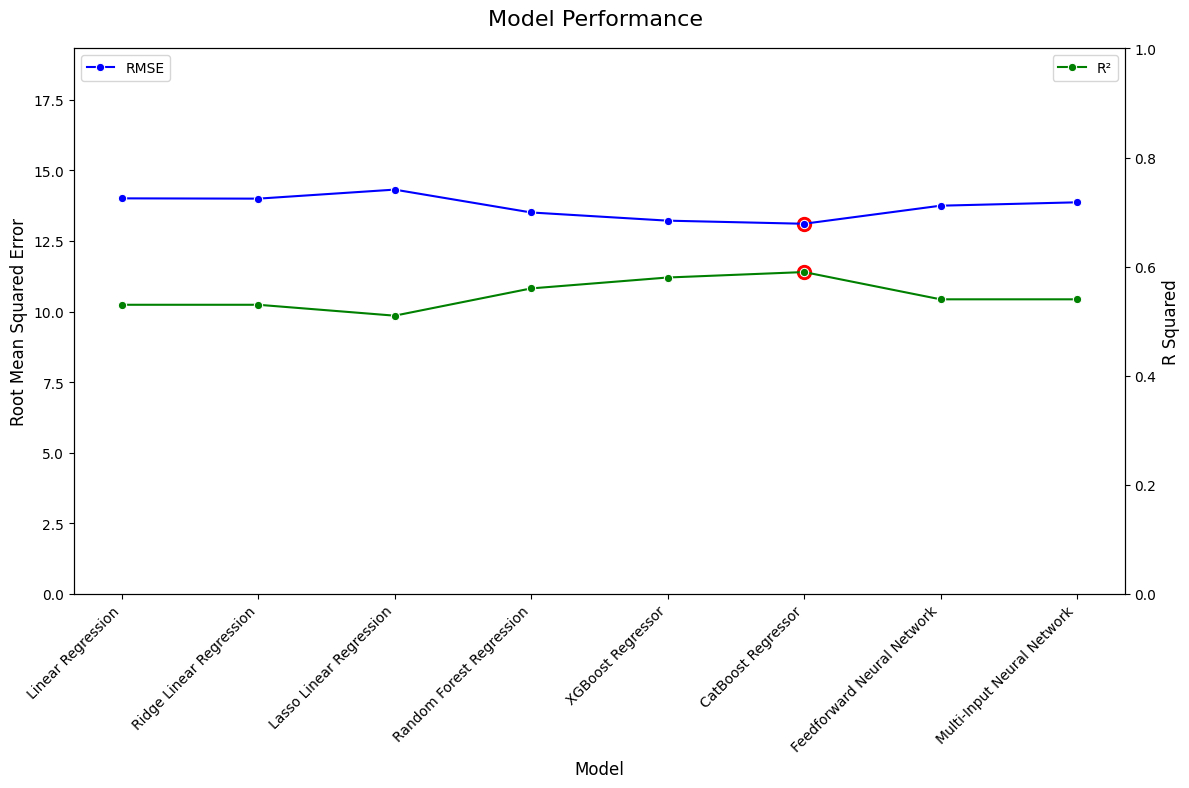

In [85]:
# Visualizing the results
model_perf = pd.DataFrame(model_perf)

fig, ax1 = plt.subplots(figsize=(12, 8))

# plot RMSE
sns.lineplot(data=model_perf, x="Model", y="RMSE", marker="o", color="blue", ax=ax1, label="RMSE")
ax1.set_ylabel("Root Mean Squared Error", fontsize=12)
ax1.set_xlabel("Model", fontsize=12)
ax1.legend(loc="upper left")
ax1.set_ylim(0, max(model_perf['RMSE']) + 5)

# highlighting the model with minimum RMSE
min_rmse_idx = model_perf['RMSE'].idxmin()
min_rmse_value = model_perf.loc[min_rmse_idx, 'RMSE']
min_rmse_model = model_perf.loc[min_rmse_idx, 'Model']
ax1.scatter(x=[min_rmse_model], y=[min_rmse_value], color="red", s=100, label="Min RMSE")

# plot R²
ax2 = ax1.twinx()
sns.lineplot(data=model_perf, x="Model", y="R Squared", marker="o", color="green", ax=ax2, label="R²")
ax2.set_ylabel("R Squared", fontsize=12)
ax2.legend(loc="upper right")
ax2.set_ylim(0, 1)

# highlighting the model with maximum R²
max_r2_idx = model_perf['R Squared'].idxmax()
max_r2_value = model_perf.loc[max_r2_idx, 'R Squared']
max_r2_model = model_perf.loc[max_r2_idx, 'Model']
ax2.scatter(x=[max_r2_model], y=[max_r2_value], color="red", s=100, label="Max R²")

# Rotate x-axis values explicitly
ax1.set_xticklabels(model_perf["Model"], rotation=45, ha='right')

# Add title and adjust layout
fig.suptitle('Model Performance', fontsize=16)
fig.tight_layout() 
plt.show()


# **Conclusion**

In [86]:
# best performing model
model_perf.loc[model_perf['Model'] == 'CatBoost Regressor']

,Model,RMSE,R Squared
5,CatBoost Regressor,13.11,0.59


**CatBoost Regression** has the hightest model performance compared to other models with **Root Mean Squared Error: 13.11** and **R Squared: 0.59**.

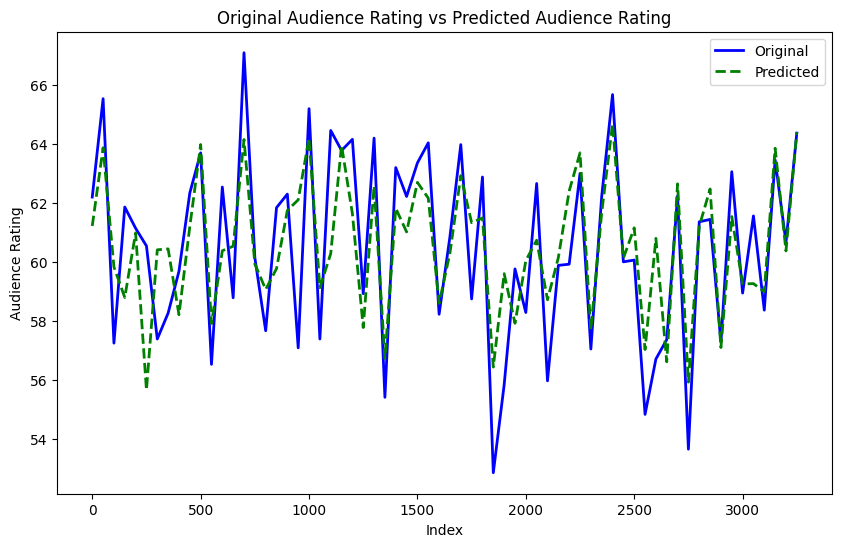

In [87]:
# Plotting Original vs Predicted values (CatBoost Regressor)
df = pd.DataFrame({
    'Index': np.arange(len(y_test)),
    'Original': y_test,
    'Predicted': catboost_reg.predict(X_test)
})

df['Bucket'] = (df['Index'] // 50) * 50
bucketed_df = df.groupby('Bucket').agg({'Original': 'mean', 'Predicted': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=bucketed_df, x='Bucket', y='Original', label='Original', color='blue', linewidth=2)
sns.lineplot(data=bucketed_df, x='Bucket', y='Predicted', label='Predicted', color='green', linestyle='--', linewidth=2)

plt.xlabel('Index')
plt.ylabel('Audience Rating')
plt.title('Original Audience Rating vs Predicted Audience Rating')
plt.legend()

plt.show()